### Stochastic Volatilty Models
#### Seminar 1
---

# What Is Volatility

In [3]:
from typing import Callable  # type annotations

import pandas as pd
import numpy as np
from datetime import date, datetime
import yfinance as yf
from scipy import stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
DARK_THEME = True

if DARK_THEME:
    plt.style.use("dark_background")
    mpl.rcParams["figure.facecolor"] = "none"
    mpl.rcParams["axes.facecolor"] = "none"

## First Look

In [5]:
TICKER1 = "TSLA"
TICKER2 = "KO"

stock1 = yf.Ticker(TICKER1).history(start=datetime(2020, 1, 1), end=datetime(2022, 1, 1))["Close"]
stock2 = yf.Ticker(TICKER2).history(start=datetime(2020, 1, 1), end=datetime(2022, 1, 1))["Close"]

The stock price is random. How to quantify the randomness of stock price?

__Which stock is more random?__

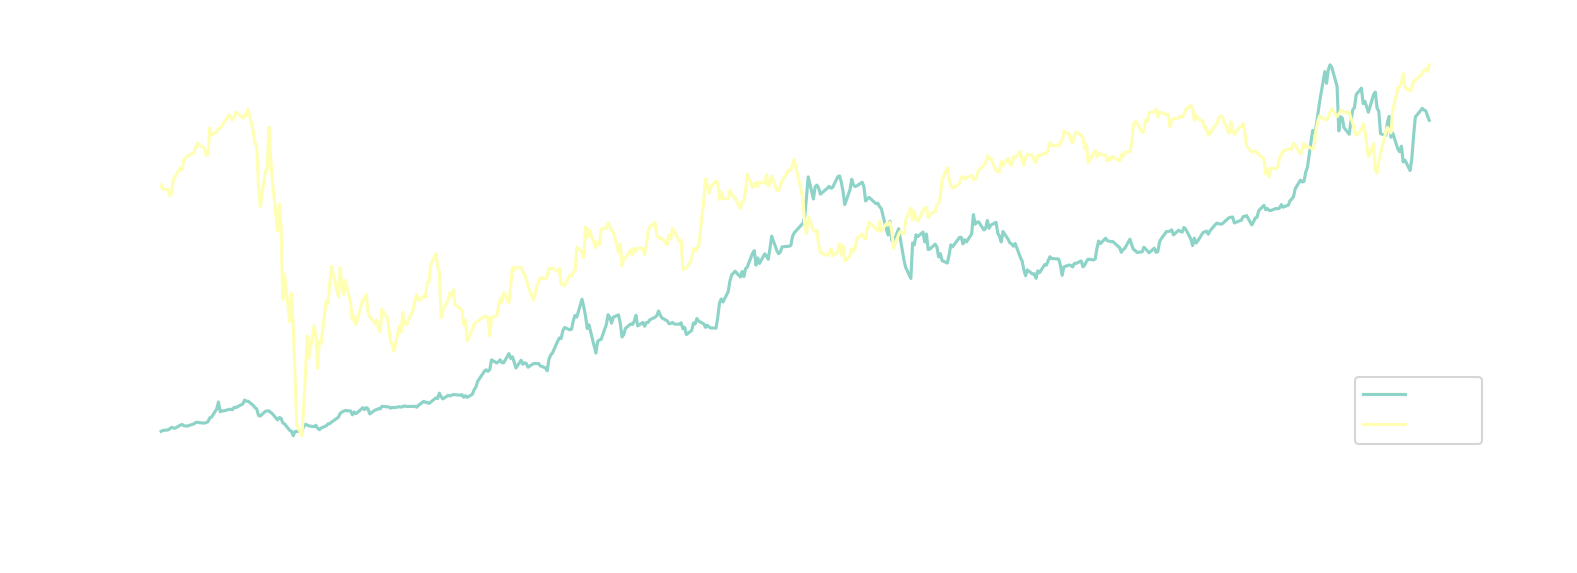

In [6]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=150)

axes1 = stock1.plot(ax=ax, c="C0")
ax.set_title("Daily stock prices")
ax.set_ylabel(f"{TICKER1} price, $")

ax = ax.twinx()
axes2 = stock2.plot(ax=ax, c="C1")
ax.set_ylabel(f"{TICKER2} price, $")

ax.legend([axes1.get_lines()[0], axes2.get_lines()[0]], [TICKER1, TICKER2], loc="lower right")
plt.show()

- The stock price can't be negative due to the limited responsibility (at least normally).
- We don't care about the stock price itself, but we do care about the **returns**.

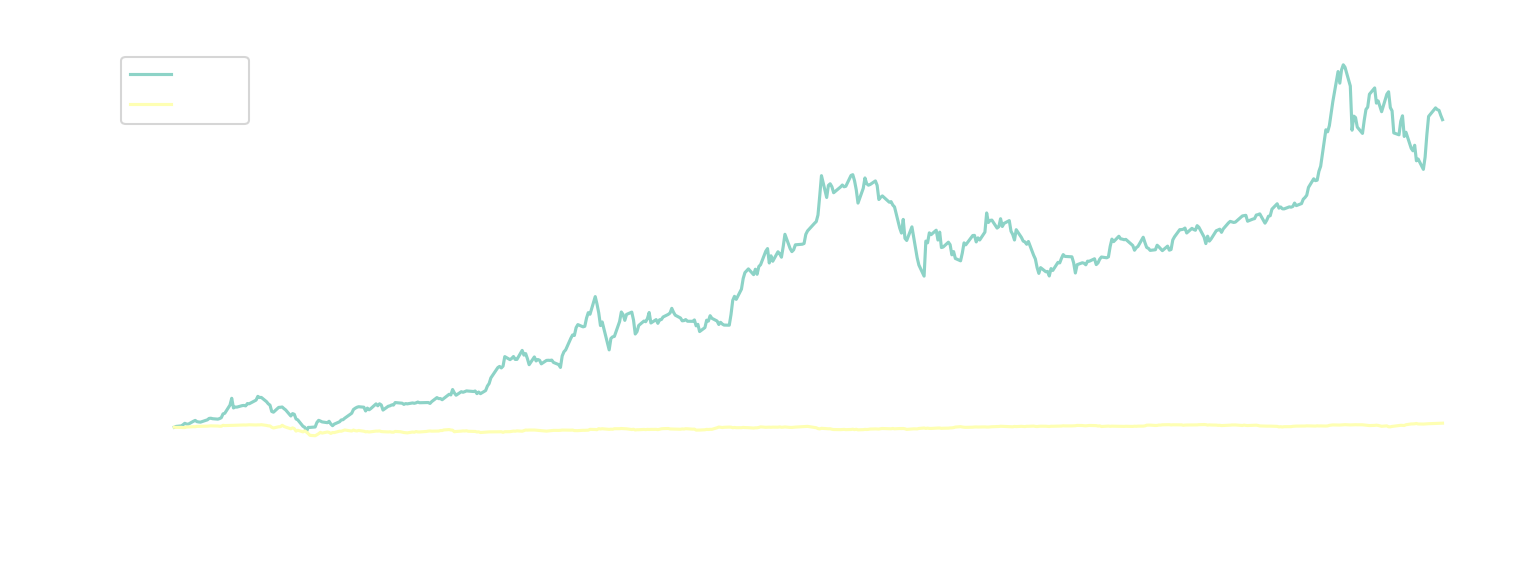

In [7]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=150)

stock1.transform(lambda s: (s / s.iat[0] - 1) * 100).plot(ax=ax, label=TICKER1)
stock2.transform(lambda s: (s / s.iat[0] - 1) * 100).plot(ax=ax, label=TICKER2)
ax.set_title(f"Stock price return to {stock1.index[0]:%F}")
ax.set_ylabel("Return, %")
ax.legend()

plt.show()

The stock price is usually anaysed in terms of **logarithmic returns**.

In [8]:
def log_return(price: pd.Series) -> pd.Series:
    return price.transform(np.log).diff()

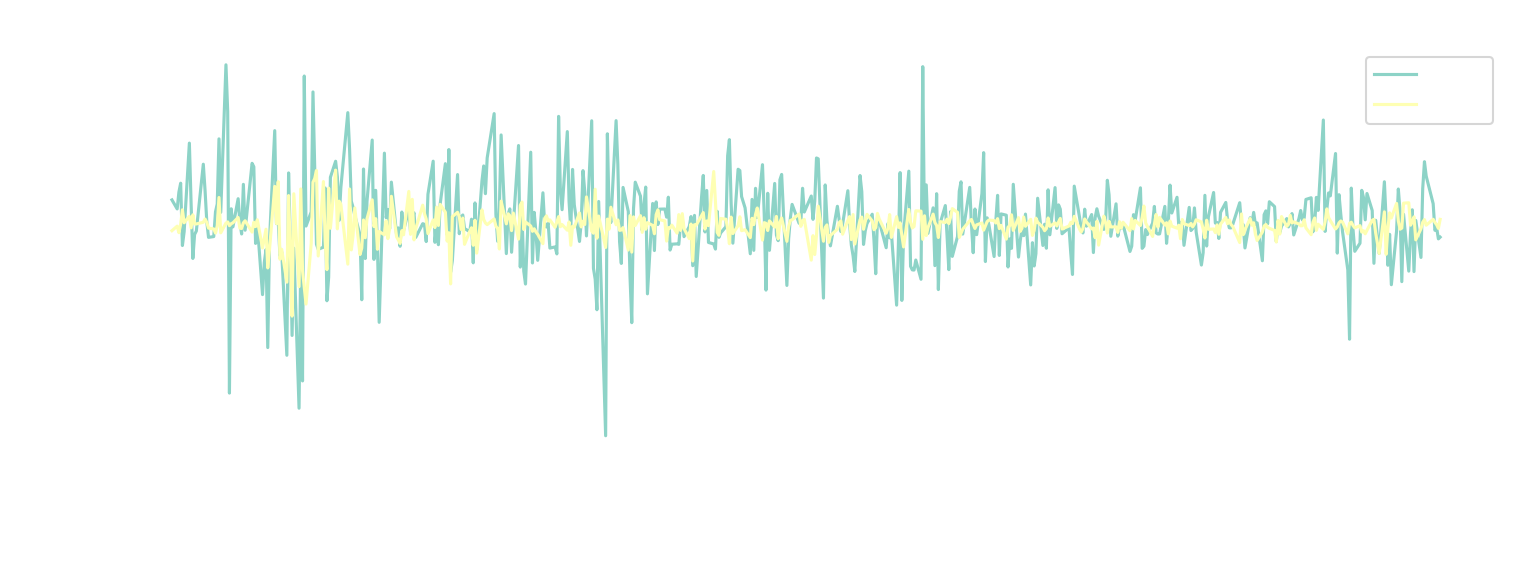

In [9]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=150)

stock1.pipe(log_return).plot(ax=ax, label=TICKER1)
stock2.pipe(log_return).plot(ax=ax, label=TICKER2)
ax.set_ylabel("Log-return")
ax.set_title("Daily logarithmic returns")
ax.legend()

plt.show()

Avg amplitude = $\mathbb{E} | x_t |$

The oscillation amplitutde of `TSLA` is larger than the one of `KO`. That's what we call ***volatility***.

## Measuring The Volatility

In [10]:
def avg_amplitude(log_ret: pd.Series) -> float:
    return log_ret.transform(np.fabs).mean()

In [11]:
aa1 = avg_amplitude(log_return(stock1))
aa2 = avg_amplitude(log_return(stock2))

print(f"The average amplitude of price oscillations of {TICKER1: ^4} is {aa1:.4f}")
print(f"The average amplitude of price oscillations of {TICKER2: ^4} is {aa2:.4f}")

The average amplitude of price oscillations of TSLA is 0.0326
The average amplitude of price oscillations of  KO  is 0.0109


Avg sq ret = $\sqrt{\mathbb{E} x_t^2}$

In [12]:
def avg_sq_ret(log_ret: pd.Series) -> float:
    return np.sqrt(log_ret.transform(np.square).mean())

In [13]:
asr1 = avg_sq_ret(log_return(stock1))
asr2 = avg_sq_ret(log_return(stock2))

print(f"The average square return of {TICKER1: ^4} is {asr1:.4f}")
print(f"The average square return of {TICKER2: ^4} is {asr2:.4f}")

The average square return of TSLA is 0.0470
The average square return of  KO  is 0.0169


## Is Volatility Stochastic?

The simplest possible stock price model is a Samuelson makret model, where the price follows a geometric Brownian motion process.
Let's check if we can rely on this model.
Within the Samuelson model log-returns are iid Gaussian rv.

In [15]:
p1 = stats.normaltest(log_return(stock1).dropna()).pvalue
p2 = stats.normaltest(log_return(stock2).dropna()).pvalue


print(f"H0: log-returns of {TICKER1: ^4} are normal iid rv. P-value: {p1:.1e}")
print(f"H0: log-returns of {TICKER2: ^4} are normal iid rv. P-value: {p2:.1e}")

H0: log-returns of TSLA are normal iid rv. P-value: 8.9e-14
H0: log-returns of  KO  are normal iid rv. P-value: 2.9e-27


May be the volatility is at least stable in time?

In [16]:
def rolling_vola_estimate(
    log_ret: pd.Series,
    vola_estimator: Callable[[pd.Series], float],
    span: str,
):
    return log_ret.rolling(span).apply(vola_estimator)

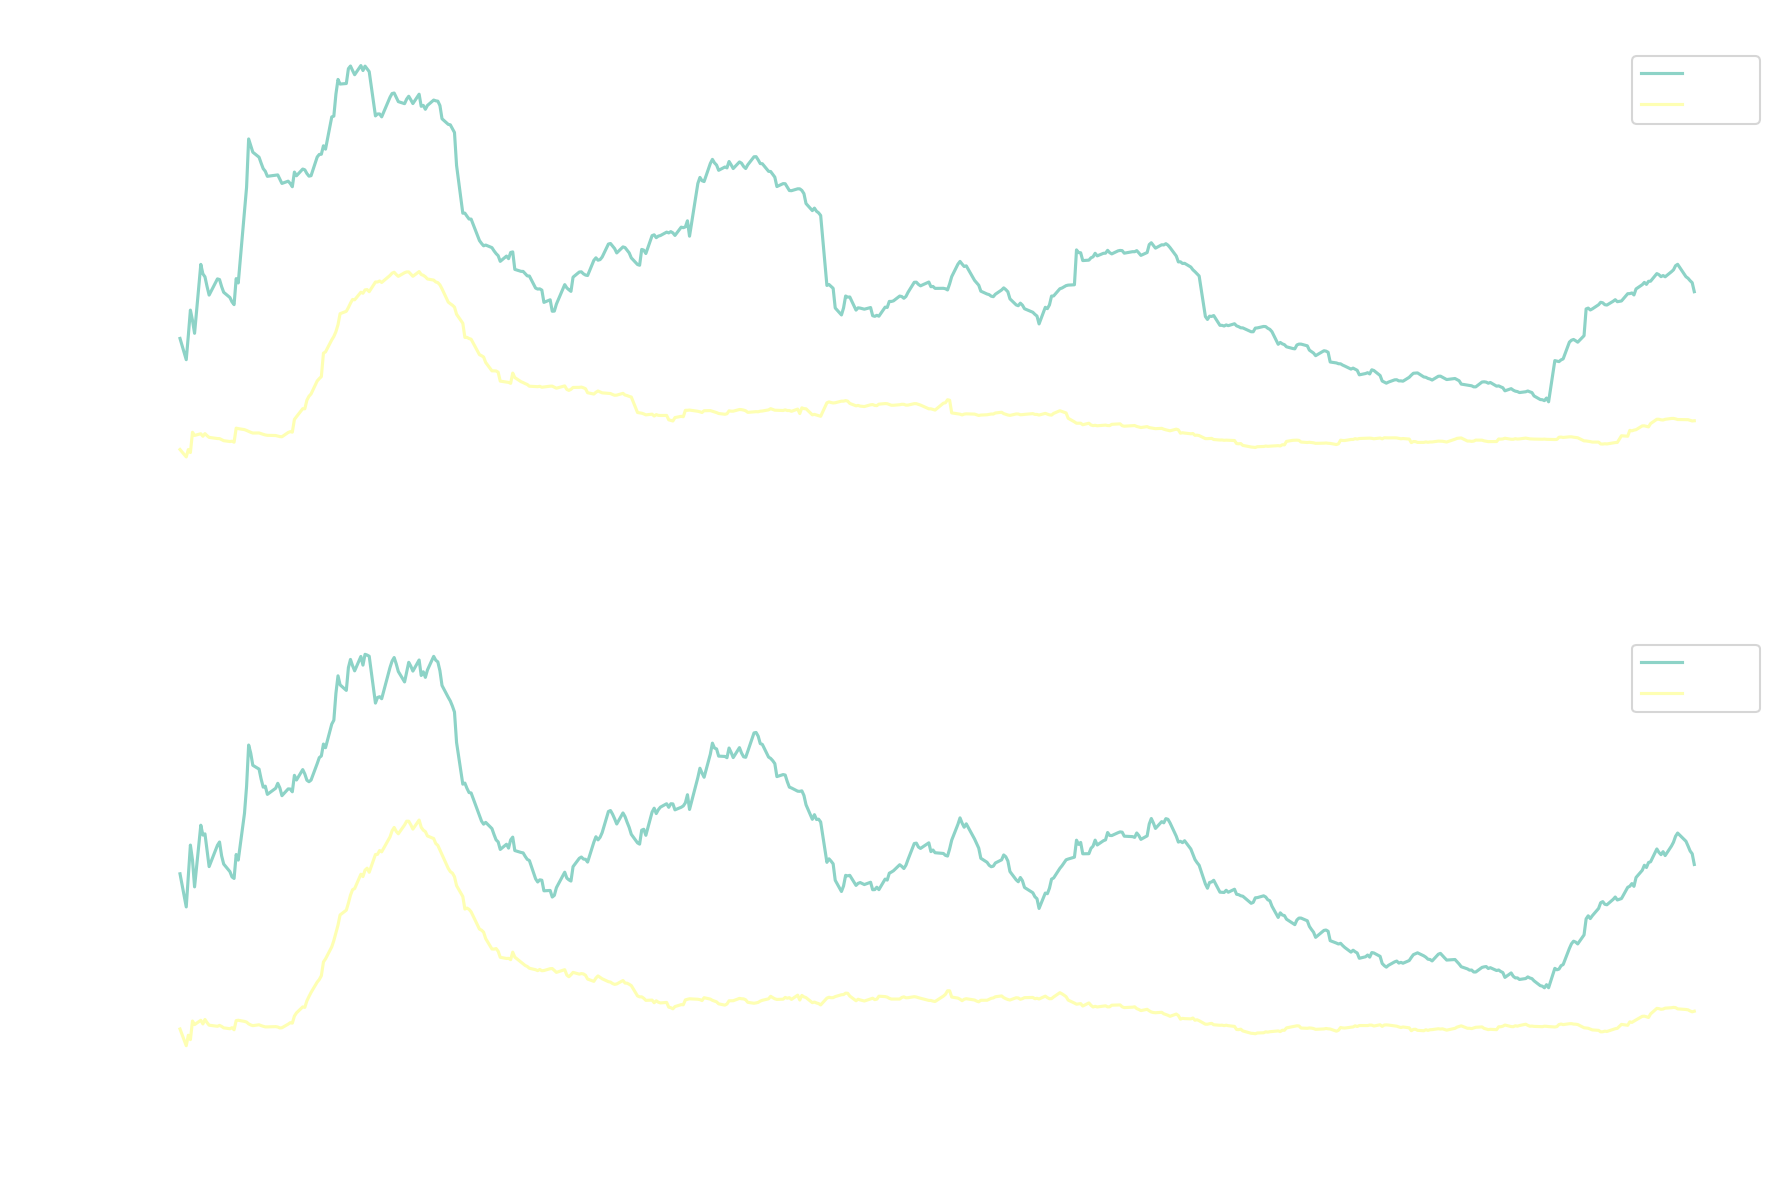

In [17]:
SPAN = "60d"
estimators = (avg_sq_ret, avg_amplitude)

_, axs = plt.subplots(nrows=2, figsize=(12, 8), dpi=150)

for ax, est in zip(axs, estimators):
    rolling_vola_estimate(log_return(stock1), est, SPAN).plot(ax=ax, label=TICKER1)
    rolling_vola_estimate(log_return(stock2), est, SPAN).plot(ax=ax, label=TICKER2)
    ax.set_title(f"Rolling {SPAN} volatility using `{est.__name__}` as an estimator")
    ax.set_ylabel("Volatility")
    ax.legend()
    
plt.tight_layout()
plt.show()

How would truly constant volatility process behave? Let's construct one and look.

In [18]:
VOLA = 0.04
SEED = 0xB0BA_C_3AB0DA

random = np.random.default_rng(SEED)
log_returns = random.normal(size=(len(stock1) - 1), scale=VOLA)
price = np.exp(np.cumsum(np.insert(log_returns, 0, 0.0)))
const_vola_price = pd.Series(index=stock1.index, data=price)

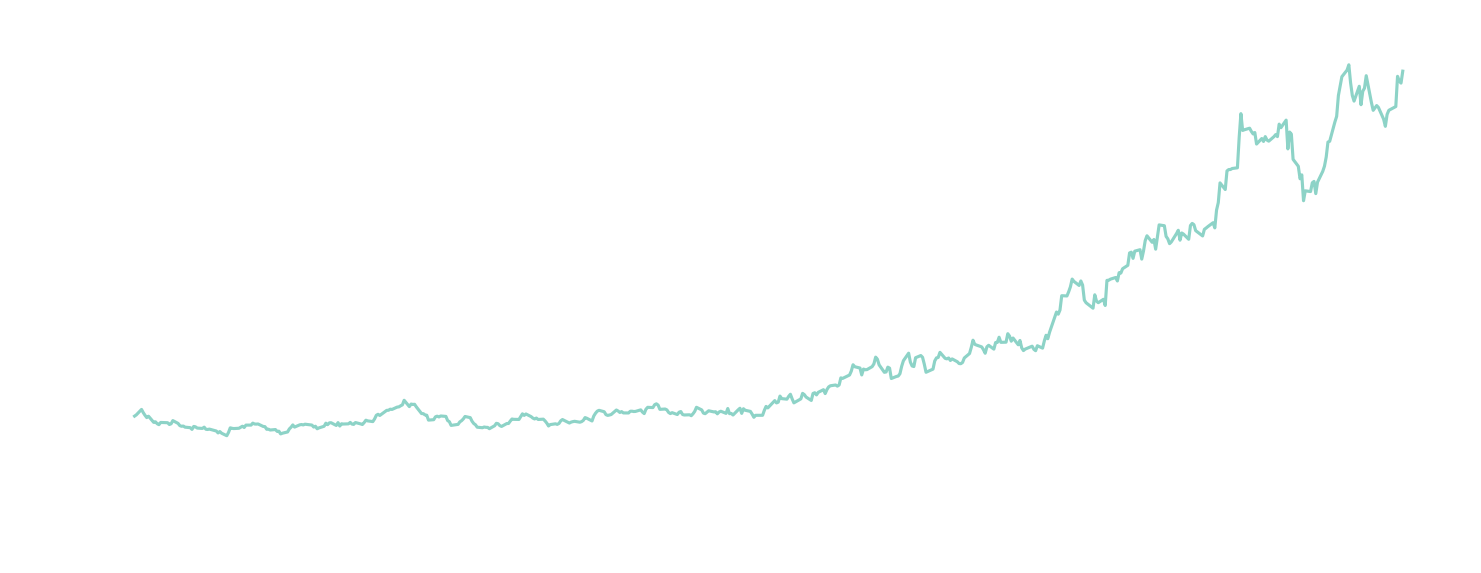

In [19]:
_, ax = plt.subplots(figsize=(12, 4), dpi=150)

const_vola_price.plot(ax=ax)
ax.set_ylabel("Price, $")
ax.set_title("Price of an ideal constant volatility stock")

plt.show()

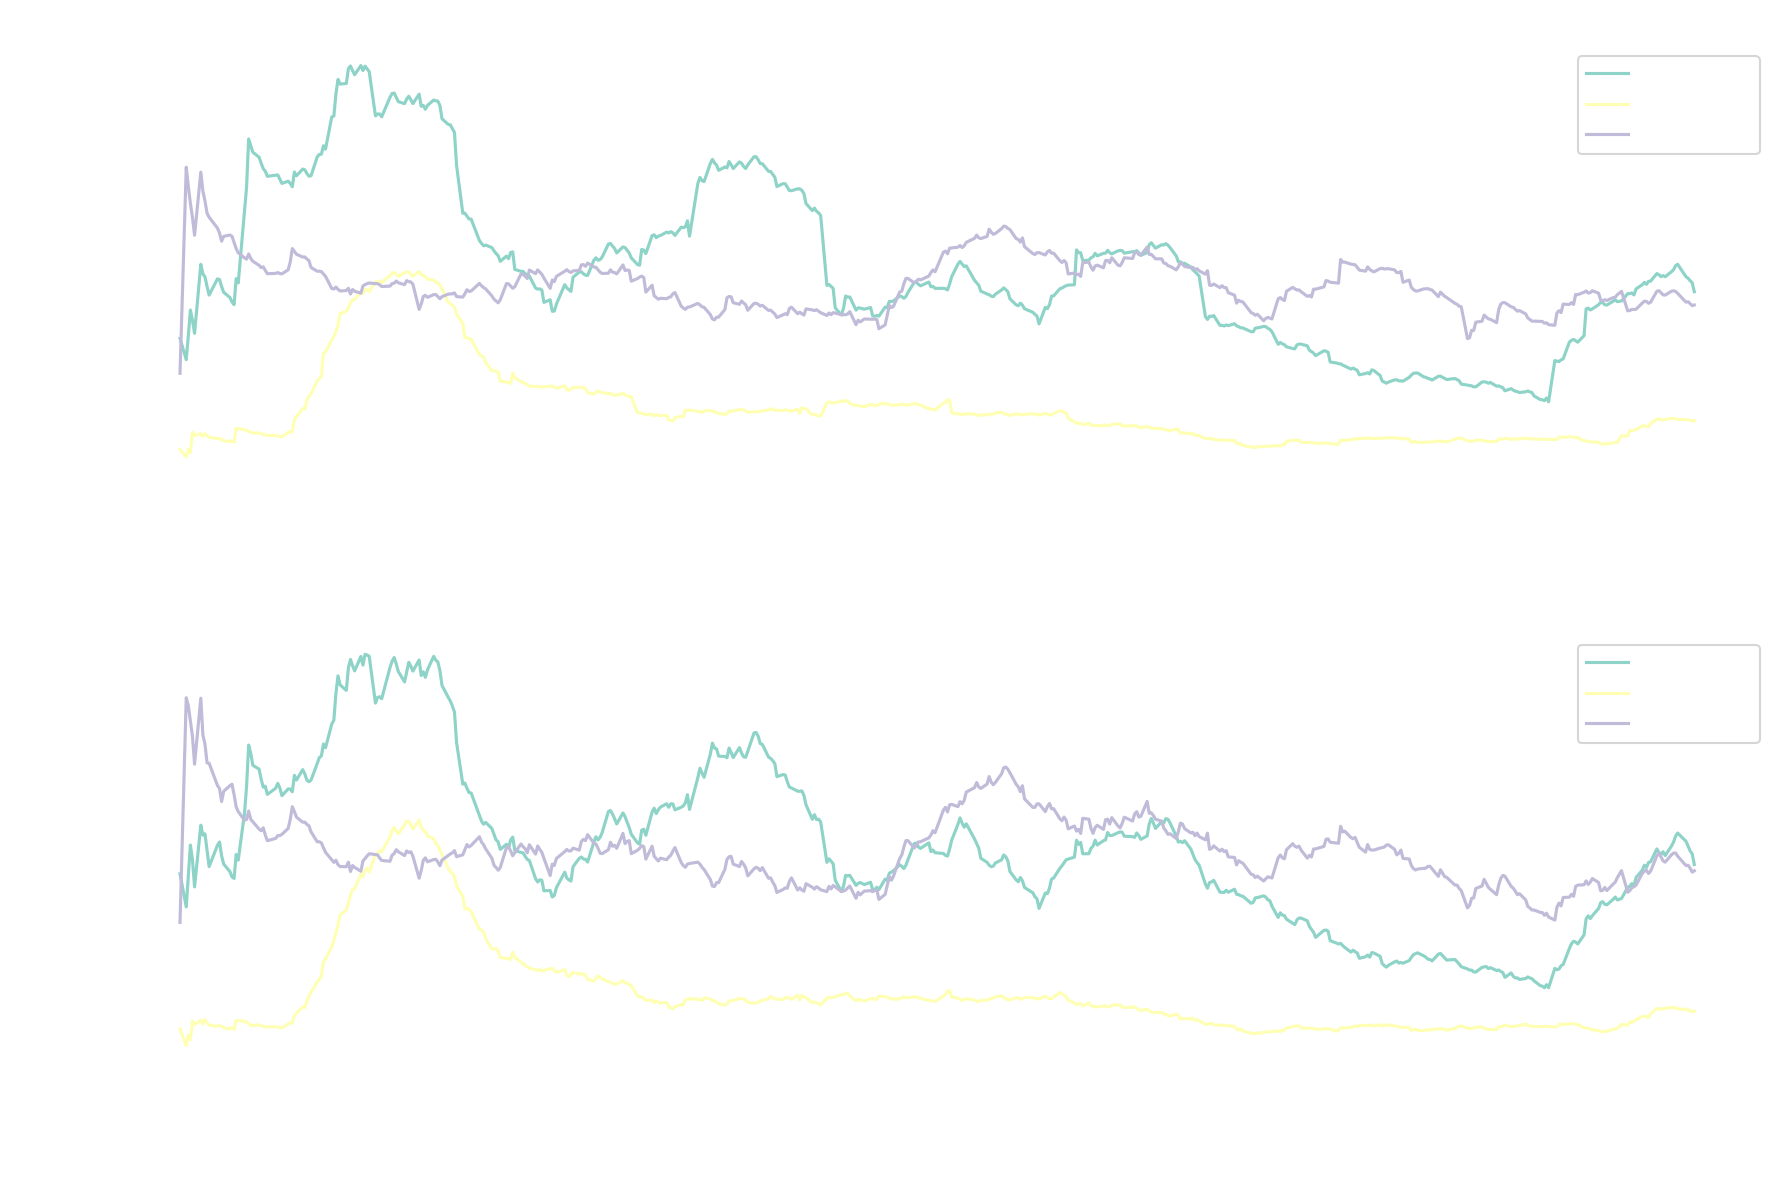

In [20]:
_, axs = plt.subplots(nrows=2, figsize=(12, 8), dpi=150)

for ax, est in zip(axs, estimators):
    rolling_vola_estimate(log_return(stock1), est, SPAN).plot(ax=ax, label=TICKER1)
    rolling_vola_estimate(log_return(stock2), est, SPAN).plot(ax=ax, label=TICKER2)
    rolling_vola_estimate(log_return(const_vola_price), est, SPAN).plot(ax=ax, label="const vola")
    ax.set_title(f"Rolling {SPAN} volatility using `{est.__name__}` as an estimator")
    ax.set_ylabel("Volatility")
    ax.legend()
    
plt.tight_layout()
plt.show()

In [21]:
VOLA = 0.04
SEED = 0xB0BA_C_3AB0DA

random = np.random.default_rng(SEED)
log_returns = random.standard_t(df=3, size=(len(stock1) - 1)) * VOLA
price = np.exp(np.cumsum(np.insert(log_returns, 0, 0.0)))
const_vola_student_price = pd.Series(index=stock1.index, data=price)

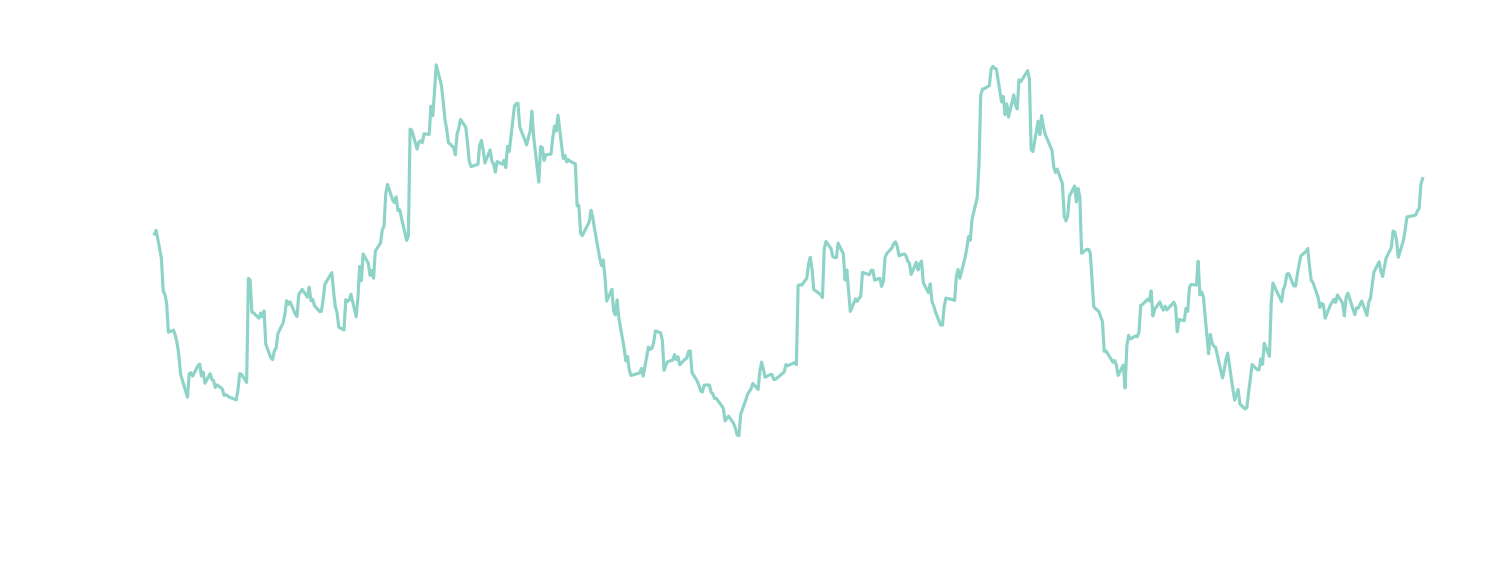

In [22]:
_, ax = plt.subplots(figsize=(12, 4), dpi=150)

const_vola_student_price.plot(ax=ax)
ax.set_ylabel("Price, $")
ax.set_title("Price of an ideal constant volatility stock with Student's t distributed log-returns")

plt.show()

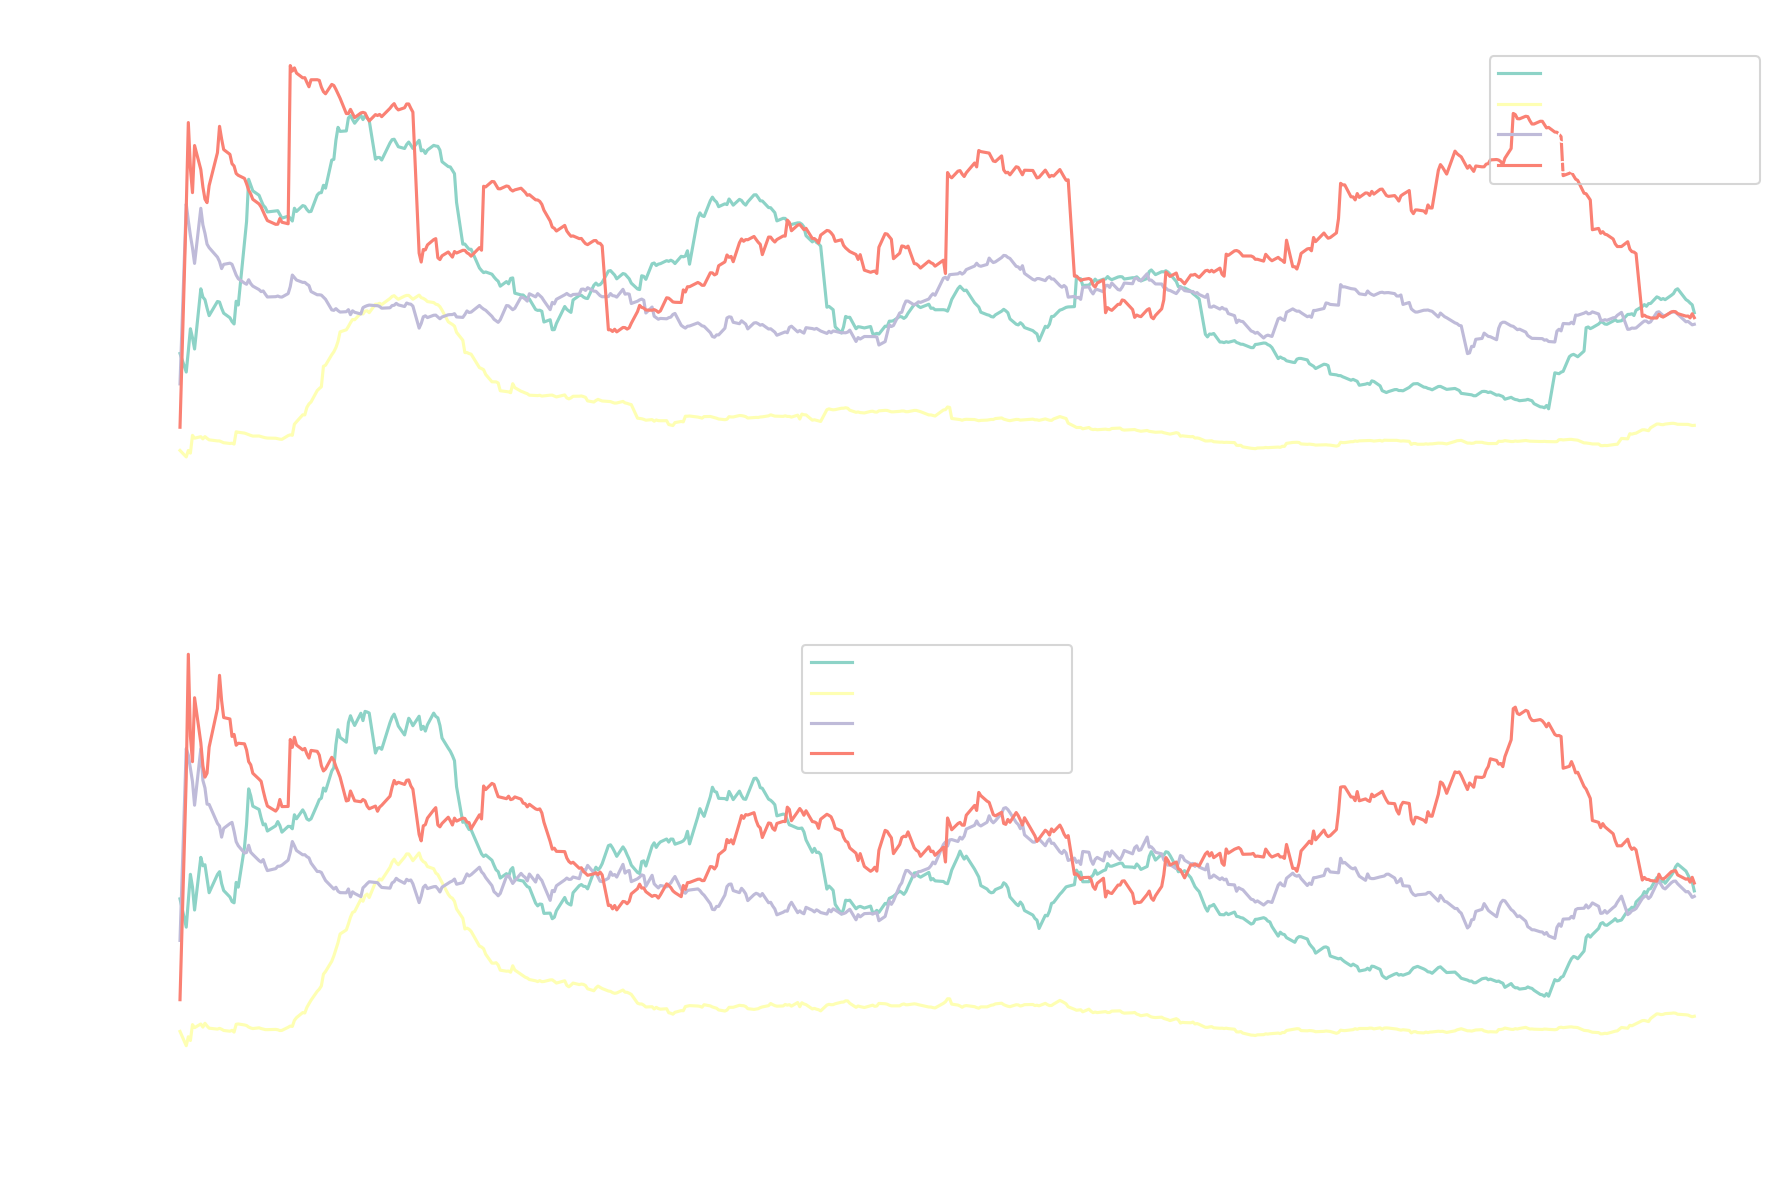

In [23]:
_, axs = plt.subplots(nrows=2, figsize=(12, 8), dpi=150)

for ax, est in zip(axs, estimators):
    rolling_vola_estimate(log_return(stock1), est, SPAN).plot(ax=ax, label=TICKER1)
    rolling_vola_estimate(log_return(stock2), est, SPAN).plot(ax=ax, label=TICKER2)
    rolling_vola_estimate(log_return(const_vola_price), est, SPAN).plot(ax=ax, label="const vola")
    rolling_vola_estimate(
        log_return(const_vola_student_price),
        est,
        SPAN
    ).plot(ax=ax, label="const vola Student")
    ax.set_title(f"Rolling {SPAN} volatility using `{est.__name__}` as an estimator")
    ax.set_ylabel("Volatility")
    ax.legend()
    
plt.tight_layout()
plt.show()

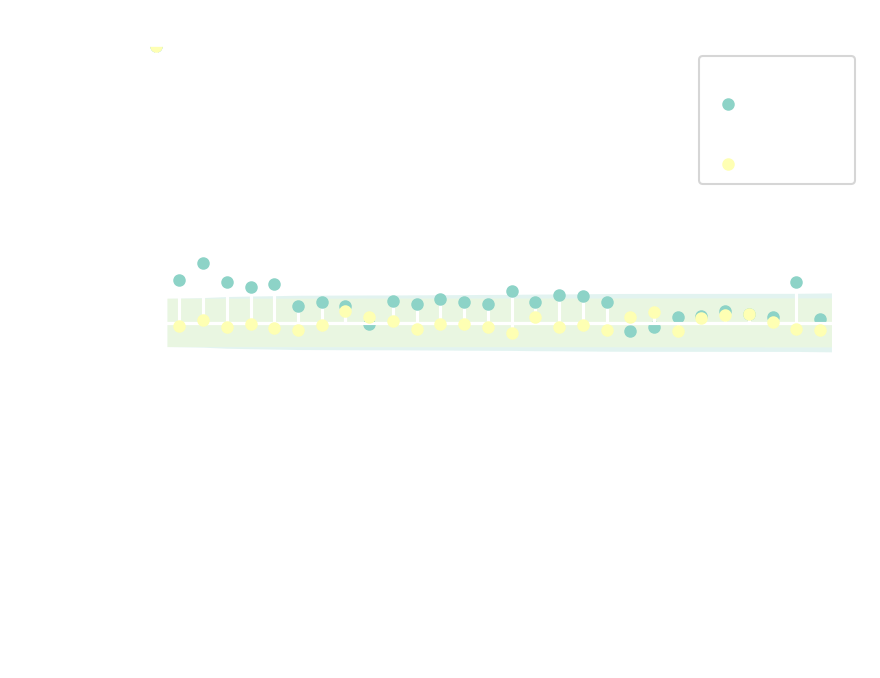

In [24]:
_, ax = plt.subplots(dpi=150)
sm.graphics.tsa.plot_acf(log_return(stock1).dropna()**2, ax=ax, label=TICKER1)
sm.graphics.tsa.plot_acf(log_return(const_vola_student_price).dropna()**2, ax=ax, label="Student")
ax.legend()
ax.set_title("Log-returns autocorrelation")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.show()

## Conclusion

It seems like we can't rely on the constant volatility assumption.
We need to model the volatility and its dynamics someway.

#### And here the course begins :)